In [1]:
import csv
import matplotlib.pyplot as plt
import json
from scipy.interpolate import RBFInterpolator
import matplotlib.tri as tri
import numpy as np
from shapely.geometry import Polygon, Point
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pyslabgrid import polygon as poly
from pyslabgrid import reckoner as reck
from pyslabgrid import mat as mat
from pyslabgrid import slabgridding as slg

# Smooth Seismicity Maps

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [3]:
def read_ratefile(infile):
    x,y,z,r = [],[],[],[]
    with open(infile, 'r') as f:
        csvreader = csv.reader(f)
        header = next(csvreader)
        for row in csvreader:
            x.append(float(row[0]))
            y.append(float(row[1]))
            z.append(float(row[2]))  
            r.append(float(row[3]))
    return x,y,z,r 

def get_boundpolygon(blon, blat):
    #
    dpoints = []
    for a,b in zip(blon, blat):
        dpoints.append((a, b))
    return Polygon(dpoints)

def get_interpfunc(lon, lat, dep, param):
    slon, slat, spar = ([],[],[])
    
    for i in range(len(dep)):
        if (param[i]<0) | np.isnan(param[i]):
            continue
        else:
            slon.append(float(lon[i]))
            slat.append(float(lat[i]))
            spar.append(float(param[i]))

    y = np.transpose([slon, slat])
    fintp = RBFInterpolator(y, np.array(spar), smoothing=0, kernel='linear')  
    #fintp = interp2d(np.array(slon), np.array(slat), np.array(spar), kind='linear')
    blon, blat = poly.boundary(slon, slat)
    pbounds = get_boundpolygon(blon, blat)
    
    return(fintp, pbounds)

def flatten(t):
    return [item for sublist in t for item in sublist]

#sc = ax.contour(x,y,r, cmap='plasma')

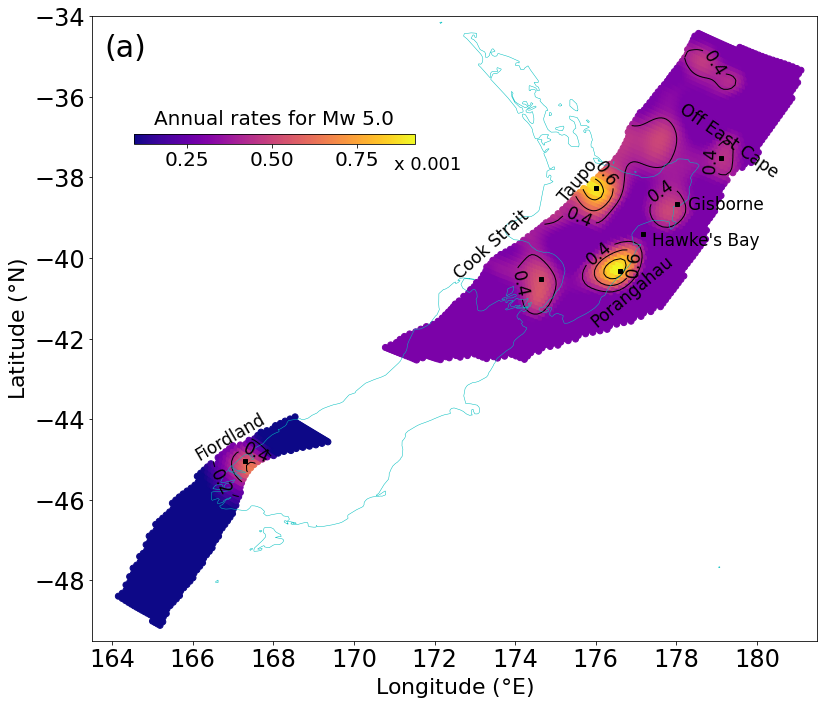

In [4]:
%matplotlib inline 

import nzborders as nzb
# transported from "Components"
outfolder = 'files/processed-smooth/'
files = ['hik-slab-smooth_1depth.csv','puy-slab-smooth_1depth.csv']

hx,hy,hz,r1 = read_ratefile(outfolder+files[0])
hr = [r*1.3638 for r in r1]
    
fhikrates, boundhik = get_interpfunc(hx, hy, hz, hr)
hxxx, hyyy = boundhik.exterior.coords.xy

px,py,pz,r2 = read_ratefile(outfolder+files[1])
pr = [r*0.14769 for r in r2]
    
fpuyrates, boundpuy = get_interpfunc(px, py, pz, pr)
pxxx, pyyy = boundpuy.exterior.coords.xy

x = hx+px
y = hy+py
z = hz+pz
r = hr+pr
R = [rr*1000 for rr in r] 

plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1,1, figsize=(13,13))
sc = ax.scatter(x,y, c=R, cmap='plasma')

# add_axes([xmin,ymin,dx,dy])
axins = fig.add_axes([0.17, 0.7, 0.3, 0.01])

cbar = fig.colorbar(sc, cax = axins, shrink=0.5, \
                    orientation='horizontal');
cbar.ax.get_xaxis().labelpad = -60
cbar.ax.set_xlabel('Annual rates for Mw 5.0', fontsize=20)
cbar.ax.tick_params(labelsize=20)
ax.text(171, -37.8,'x 0.001',fontsize=18)

nzb.plot(file='nzborders.json', plinewidth= 0.5, pcolor = 'c', ax=ax)
ax.set_xlim([163.5,181.5])
ax.set_ylim([-49.5,-34])

select_locations = {'Taupo': {'coord': (176.0,-38.27), 
                              'pcoord': (176.15,-38.27)},
                    'Porangahau': {'coord': (176.61,-40.32), 
                                   'pcoord': (176.61,-40.32)},
                    'Cook Strait': {'coord': (174.65,-40.51),
                                    'pcoord': (173.,-39.8)},
                    
                    'Off East Cape': {'coord': (179.1, -37.53),
                                     'pcoord': (178.2, -37)},
                    'Fiordland': {'coord': (167.31, -45.05),
                                 'pcoord': (167.31, -45.05),},
                    
                    'Hawkes Bay': {'coord': (177.18, -39.41),
                                    'pcoord': (177.15, -39.7)},
                    
                    'Gisborne': {'coord': (178.02, -38.66),
                                'pcoord': (178., -38.66)},
                    } 

    
x, y = np.array(x), np.array(y)    
triang = tri.Triangulation(x, y)
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)

mask = []
for xm, ym in zip(xmid, ymid):
    if not boundhik.contains(Point(xm, ym))|boundpuy.contains(Point(xm, ym)):
        mask.append(True)
    else:
        mask.append(False)

triang.set_mask(mask)

CS1 = ax.tricontour(triang, R, 4, linewidths=1, colors='k')
ax.clabel(CS1, CS1.levels, fontsize=17, colors='k')
ax.set_xlabel('Longitude ($\xb0$E)', fontsize=22)
ax.set_ylabel('Latitude ($\xb0$N)', fontsize=22)
#ax.clabel(CS1,fontsize=10,inline=True, colors='k')

fsi=17
ax.text(172.4, -40.5, 'Cook Strait', fontsize= fsi, rotation = 42)
ax.text(178, -38., 'Off East Cape', fontsize= fsi, rotation = -35)
ax.text(177.4, -39.7,'Hawke\'s Bay', fontsize= fsi, )
ax.text(178.3, -38.8, 'Gisborne', fontsize= fsi, )
ax.text(166., -45.,'Fiordland', fontsize= fsi, rotation = 30)
ax.text(175., -38.6,'Taupo', fontsize= fsi, rotation = 50)
ax.text(175.8, -41.7, 'Porangahau', fontsize= fsi, rotation = 40)

for loc in select_locations:
    lonlat = select_locations[loc]['coord']
    ax.plot(lonlat[0], lonlat[1], 'ks', markersize=4)
    
ax.set_aspect('equal', adjustable='box')
ax.text(163.8,-35,'(a)', fontsize=30)
fig.savefig('Figure8A.jpeg', dpi=300, facecolor='w');

In [5]:
# get rates 

rates = {}
for loc in select_locations:
    lonlat = select_locations[loc]['coord']
    if loc == 'Fiordland':
        xrate = fpuyrates(np.transpose([[lonlat[0]], [lonlat[1]]]))
    else:
        xrate = fhikrates(np.transpose([[lonlat[0]], [lonlat[1]]]))
    rates.update({loc:xrate[0]})

brate = rates['Taupo']
print('location , relative rate (wrt Taupo)')
for rrr in rates:
#     if (rrr == 'Fiordland'):
#         print(rrr, '|', (rates[rrr]-brate)/brate*100)
#     else:
      print(rrr, '|', rates[rrr]/brate)
    

location , relative rate (wrt Taupo)
Taupo | 1.0
Porangahau | 0.9841960117979262
Cook Strait | 0.5941043498468145
Off East Cape | 0.5022359808127521
Fiordland | 0.6329304427873164
Hawkes Bay | 0.33204841270464497
Gisborne | 0.5210649218230191


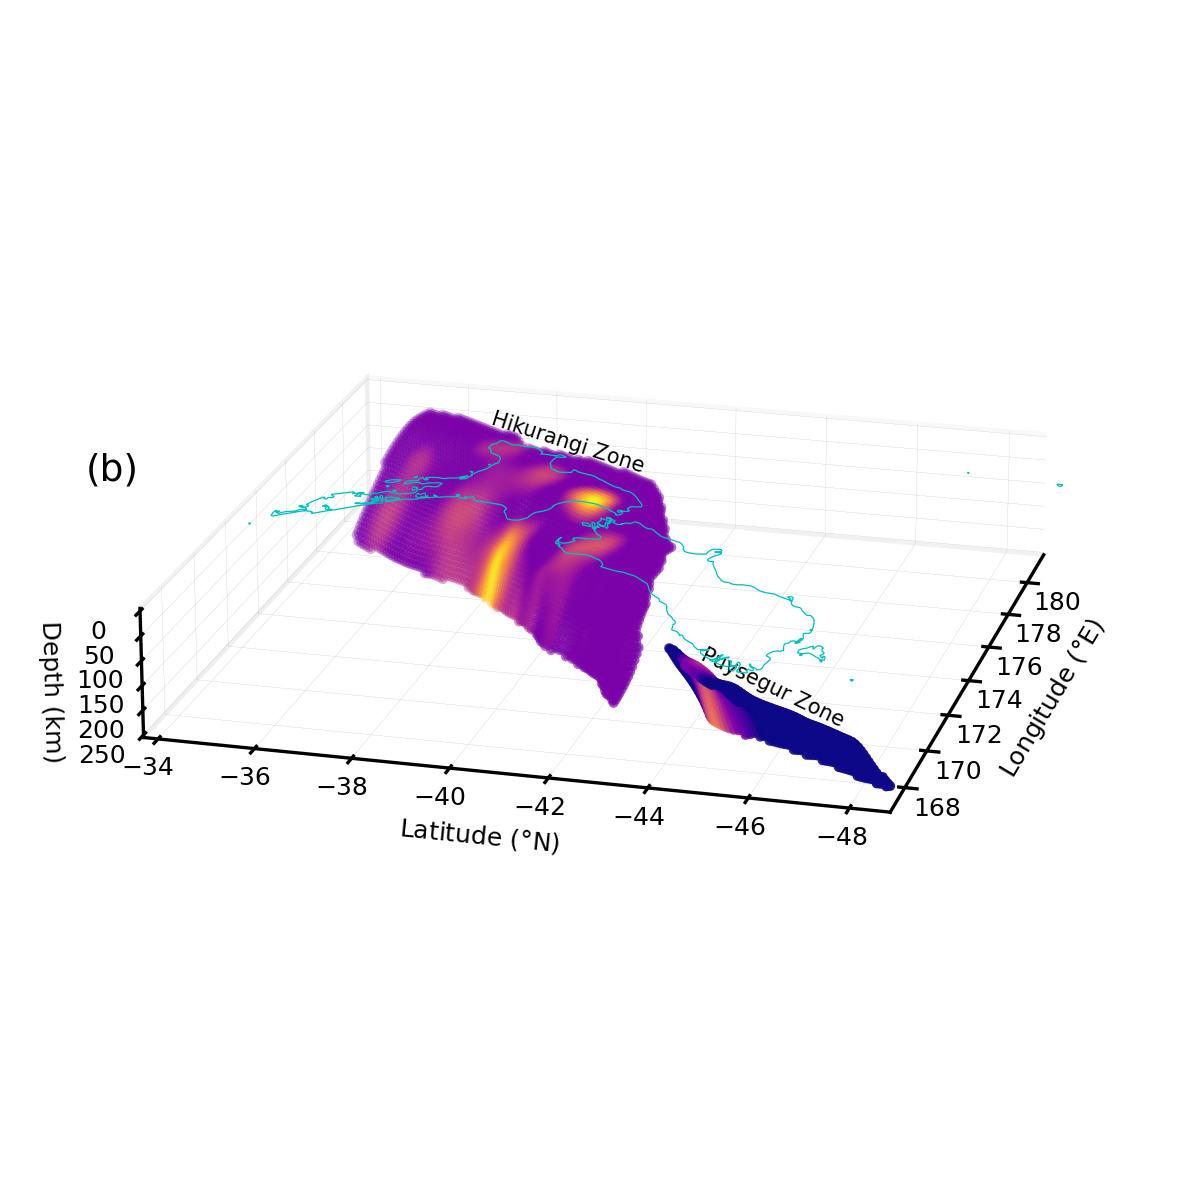

In [7]:
%matplotlib inline
plt.rcParams.update({'font.size': 6})
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(8,5), dpi=300)
#fig = plt.figure(figsize=(8, 8), dpi=180)

ax = fig.add_subplot(projection='3d')
#z_deg = [d/111.0 for d in z]

rr = [x*1000 for x in r]
sc = ax.scatter3D(x, y, z, c=rr, s=2, cmap = 'plasma')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis._axinfo["grid"].update({"linewidth":0.05})
ax.yaxis._axinfo["grid"].update({"linewidth":0.05})
ax.zaxis._axinfo["grid"].update({"linewidth":0.05})
#ax.grid(False)
#x0,y0, W, H
#cax = fig.add_axes([0.65, 0.4, 0.007, 0.13])
# cax = fig.add_axes([0.63, 0.6, 0.16, 0.004])
# cbar = fig.colorbar(sc, cax = cax, orientation='horizontal');

# cbar.ax.tick_params(labelsize=5, pad=1)
# #cbar.ax.set_xlabel('1000 x [annual rates for Mw 5.0]',fontsize=5, labelpad=-18)

f = open("nzborders.json")
border = json.load(f)
f.close()
# 
brlon, brlat = [],[]
for xx,yy in zip(border['lon'], border['lat']):
    if xx>180:
        continue;
    if yy<-50:
        continue;
    brlon.append(xx)
    brlat.append(yy)

ax.plot3D(brlon, brlat,[0]*len(brlon),'-',\
              linewidth= 0.3, color='c', zorder=4);

ax.tick_params(axis="y", pad=-2)
ax.tick_params(axis="z", pad=-2)
ax.tick_params(axis="x", pad=-2)

ax.set_xlabel('Longitude ($\xb0$E)', labelpad= -5)
ax.set_ylabel('Latitude ($\xb0$N)', labelpad= 0)
ax.set_zlabel('Depth (km)', labelpad= -8)

ax.set_box_aspect((1, 1, 0.18), zoom=0.9)
ax.set_xlim([167.0,181.5])
ax.set_ylim([-48.5,-34])
ax.set_zlim(0, 250)
ax.invert_zaxis()
#ax.view_init(elev=20., azim=-175)
ax.view_init(elev=20., azim=-165)

ax.text(176.5,-38, 0, 'Hikurangi Zone', (0.08, 0.1, 1), fontsize=5)
ax.text(163.5,-45.8, 0, 'Puysegur Zone', (0.1, 0.1, 1), fontsize=5)
axins = fig.add_axes([0.3, 0.58, 0.1, 0.1])
axins.text(0., 0., '(b)', fontsize=9)
axins.axis('off');
fig.savefig('Figure8B.jpeg', dpi=300, facecolor='w', bbox_inches='tight');